notebook to mess around with GCNs for lorenz. WORK IN PROGRESS.

### imports


In [1]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

# libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import Dense

from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras.metrics import RootMeanSquaredError, MeanSquaredError
from spektral.layers import GCNConv, GlobalSumPool
from spektral.models import GCN
from spektral.data import MixedLoader
from lorenz import lorenzDataset, plot_with_predictions

2022-11-18 13:47:32.878042: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### prepare data


In [2]:
DEFAULT_TIME_RESOLUTION = 0.01

THINGS TO TRY 
write helper functions! 
- play with diff sample size (500) - v
- input/output day ratio - h 
- play around with buffer - v
- activation layers - h
- play with the hidden layers - v 
- diff data samples / diff lorenz params - h 
- diff optimizer alg - v 
- add feature engineering (e.g. sinusoids for time variable)

In [3]:
# TODO: add logging to see progress
dataset = lorenzDataset(
    n_samples=10000,
    input_steps=5 * DEFAULT_TIME_RESOLUTION,  # 2 days
    output_delay=1 * DEFAULT_TIME_RESOLUTION,  # 1 day
    output_steps=1,
    min_buffer=10,
    rand_buffer=False,
    K=36,
    F=8,
    c=10,
    b=10,
    h=1,
    coupled=True,
    time_resolution=DEFAULT_TIME_RESOLUTION,
    seed=42)

In [4]:
# inspect dataset
print(dataset)
print(dataset[0])

lorenzDataset(n_graphs=100)
Graph(n_nodes=36, n_node_features=1000, n_edge_features=None, n_labels=1)


In [5]:
# split test/train data
# we can't use the keras split_dataset() function here because our Dataset
# class is incompatible
# we also cannot shuffle our data
train = dataset[:int(0.7 * dataset.n_graphs)]
val = dataset[int(0.7 * dataset.n_graphs):int(0.9 * dataset.n_graphs)]
test = dataset[int(0.9 * dataset.n_graphs):]

train_loader = MixedLoader(dataset=train, batch_size=32)
val_loader = MixedLoader(dataset=val, batch_size=32)
test_loader = MixedLoader(dataset=test, batch_size=32)

In [6]:
# normalize the data using the training set's mean and stdev
# TODO: verify that get_mean_std() is actually correct
X1_mean, X1_std, X2_mean, X2_std = train.get_mean_std()
print('X1_mean', X1_mean)
print('X1_std', X1_std)
print('X2_mean', X2_mean)
print('X2_std', X2_std)

train.normalize(X1_mean, X1_std, X2_mean, X2_std)
val.normalize(X1_mean, X1_std, X2_mean, X2_std)
test.normalize(X1_mean, X1_std, X2_mean, X2_std)

X1_mean 2.366337151371561
X1_std 3.5351438259326553
X2_mean 0.08382469050951195
X2_std 0.251667216236199


In [7]:
# check that the normalization was successful, i.e. the train data should have
# a mean of exactly 0 and a stdev of exactly 1; val and test should have means
# near 0 and stdevs near 1
X1_mean, X1_std, X2_mean, X2_std = train.get_mean_std()
print('statistics for train set')
print('X1_mean', X1_mean)
print('X1_std', X1_std)
print('X2_mean', X2_mean)
print('X2_std', X2_std)

X1_mean, X1_std, X2_mean, X2_std = val.get_mean_std()
print('\nstatistics for val set')
print('X1_mean', X1_mean)
print('X1_std', X1_std)
print('X2_mean', X2_mean)
print('X2_std', X2_std)

X1_mean, X1_std, X2_mean, X2_std = test.get_mean_std()
print('\nstatistics for test set')
print('X1_mean', X1_mean)
print('X1_std', X1_std)
print('X2_mean', X2_mean)
print('X2_std', X2_std)


statistics for train set
X1_mean -1.2750170831864106e-16
X1_std 0.9999999999999996
X2_mean 3.4060937491992103e-17
X2_std 1.0

statistics for val set
X1_mean -0.00492598716724943
X1_std 0.991888623895884
X2_mean -0.00025266422361596574
X2_std 0.9609322900706312

statistics for test set
X1_mean -0.0276845913263534
X1_std 0.9794567148017548
X2_mean -0.009970516144109117
X2_std 0.9392186390487864


#### inspect our data

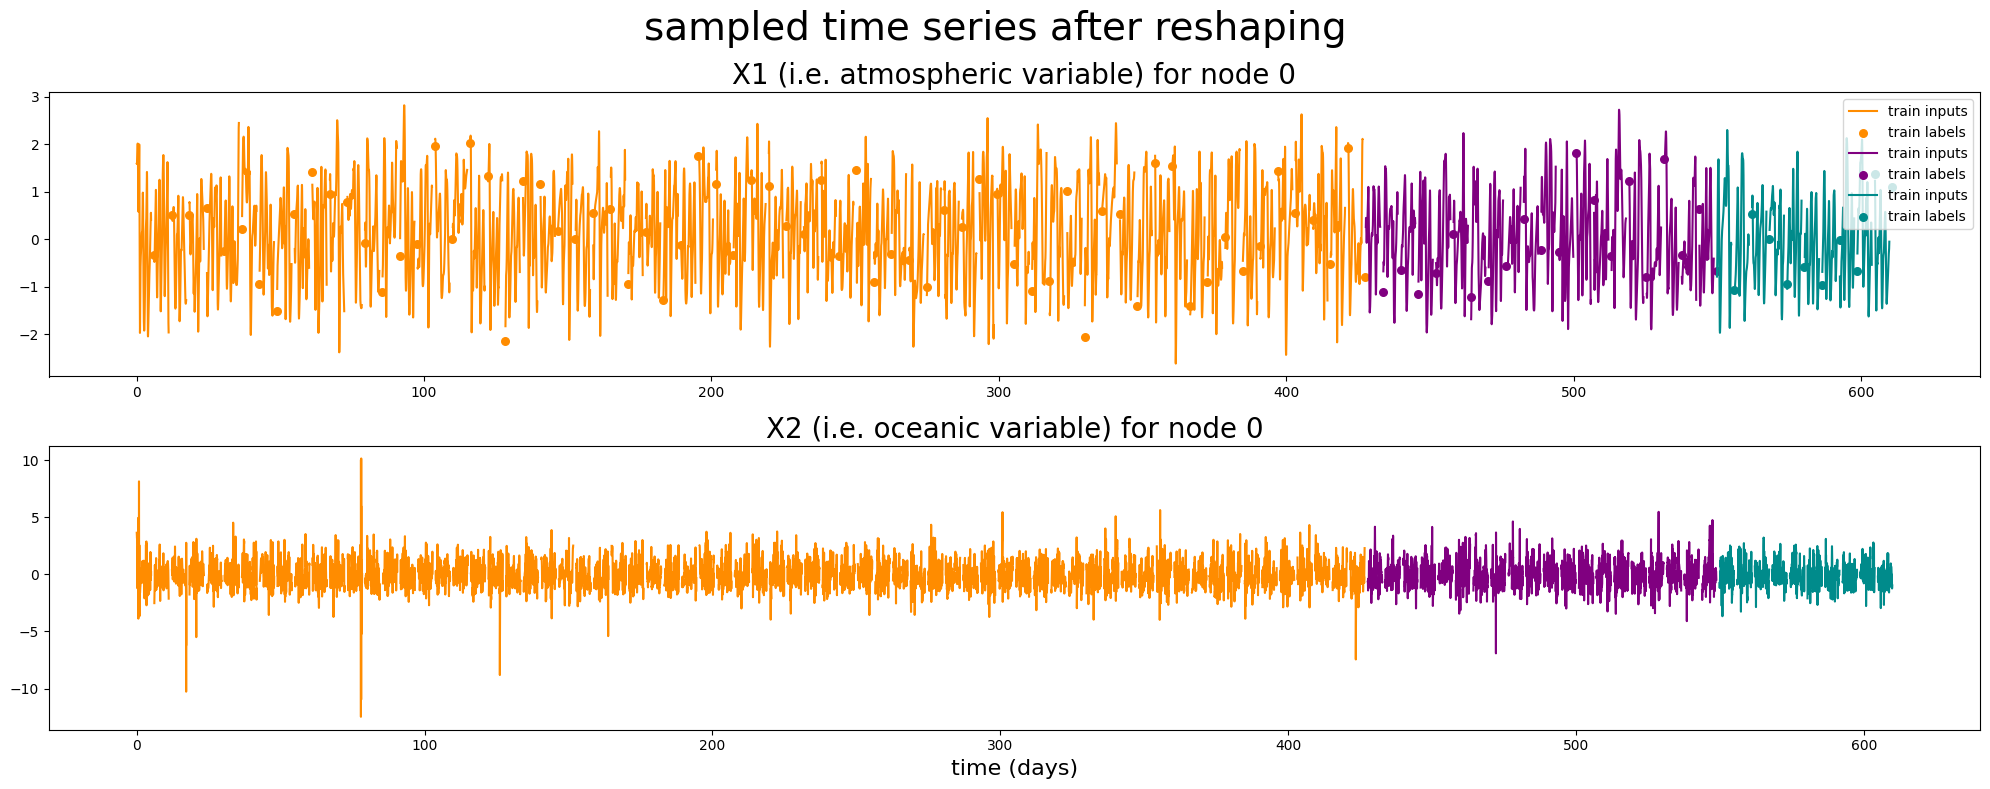

In [8]:
colors = ["darkorange", "purple", "darkcyan"]
node = 0

# set up plot
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(20, 8))

fig.suptitle("sampled time series after reshaping", size=28)
ax0.set_title("X1 (i.e. atmospheric variable) for node {}".format(node),
              size=20)
ax1.set_title("X2 (i.e. oceanic variable) for node {}".format(node), size=20)
plt.xlabel('time (days)', size=16)

# plot train, val, and test data
fig, (ax0, ax1) = train.plot(node,
                             fig,
                             ax0,
                             ax1,
                             data_type='train',
                             color=colors[0])
fig, (ax0, ax1) = val.plot(node,
                           fig,
                           ax0,
                           ax1,
                           data_type='val',
                           color=colors[1])
fig, (ax0, ax1) = test.plot(node,
                            fig,
                            ax0,
                            ax1,
                            data_type='test',
                            color=colors[2])

# create legend
ax0.legend()
ax0.legend(handles=ax0.get_legend().legendHandles[0:6])
leg = ax0.get_legend()
[
    leg.legendHandles[i].set_color(colors[i // 2])
    for i in range(len(leg.legendHandles))
]

plt.tight_layout()
plt.show()

### out-of-the-box GCN

#### sanity check: initial error is reasonable

our final layer is a linear function. therefore, for the first epoch, when all our weights are initialized randomly and we set the regularization to 0, we would expect the error to be: ???

In [9]:
sanity_check_model1 = GCN(
    n_labels=1,
    channels=32,  # same thing as n_hidden
    activation="relu",
    output_activation=None,
    use_bias=False,
    dropout_rate=0,
    l2_reg=0)
sanity_check_model1.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=[MeanSquaredError(), RootMeanSquaredError()])
history = sanity_check_model1.fit(train_loader.load(),
                                  steps_per_epoch=train_loader.steps_per_epoch,
                                  epochs=10)


Epoch 1/10


2022-11-18 13:48:24.390934: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/Guest/lorenzGNN/venv/lib/python3.10/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'lorenzDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3/3 [==============================] - 2s 10ms/step - loss: 35.8584 - mean_squared_error: 40.3622 - root_mean_squared_error: 6.3422
Epoch 2/10
3/3 [==============================] - 0s 10ms/step - loss: 13.0195 - mean_squared_error: 26.1777 - root_mean_squared_error: 5.1124
Epoch 3/10
3/3 [==============================] - 0s 6ms/step - loss: 11.7844 - mean_squared_error: 20.9650 - root_mean_squared_error: 4.5778
Epoch 4/10
3/3 [==============================] - 0s 6ms/step - loss: 8.1937 - mean_squared_error: 17.7753 - root_mean_squared_error: 4.2154
Epoch 5/10
3/3 [==============================] - 0s 6ms/step - loss: 5.5370 - mean_squared_error: 15.2918 - root_mean_squared_error: 3.9099
Epoch 6/10
3/3 [==============================] - 0s 7ms/step - loss: 5.3116 - mean_squared_error: 13.5816 - root_mean_squared_error: 3.6850
Epoch 7/10
3/3 [==============================] - 0s 7ms/step - loss: 5.2013 - mean_squared_error: 12.3624 - root_mean_squared_error: 3.5158
Epoch 8/10
3/3 [===

#### sanity check: increasing regularization causes increasing loss

regularization reduces the amount of overfitting, thus increasing the loss on the training set

In [10]:
sanity_check_model2 = GCN(
    n_labels=1,
    channels=32,  # same thing as n_hidden
    activation="relu",
    output_activation=None,
    use_bias=False,
    dropout_rate=0.5,
    l2_reg=5e-4)
sanity_check_model2.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=[MeanSquaredError(), RootMeanSquaredError()])
history = sanity_check_model2.fit(train_loader.load(),
                                  steps_per_epoch=train_loader.steps_per_epoch,
                                  epochs=10)


Epoch 1/10
3/3 [==============================] - 1s 9ms/step - loss: 56.9659 - mean_squared_error: 58.7496 - root_mean_squared_error: 7.6644
Epoch 2/10
3/3 [==============================] - 0s 8ms/step - loss: 49.2314 - mean_squared_error: 54.4764 - root_mean_squared_error: 7.3805
Epoch 3/10
3/3 [==============================] - 0s 8ms/step - loss: 45.7715 - mean_squared_error: 51.6068 - root_mean_squared_error: 7.1836
Epoch 4/10
3/3 [==============================] - 0s 8ms/step - loss: 41.6878 - mean_squared_error: 49.4332 - root_mean_squared_error: 7.0307
Epoch 5/10
3/3 [==============================] - 0s 8ms/step - loss: 42.6453 - mean_squared_error: 47.6934 - root_mean_squared_error: 6.9060
Epoch 6/10
3/3 [==============================] - 0s 8ms/step - loss: 39.7680 - mean_squared_error: 46.3971 - root_mean_squared_error: 6.8115
Epoch 7/10
3/3 [==============================] - 0s 8ms/step - loss: 32.8877 - mean_squared_error: 44.7117 - root_mean_squared_error: 6.6866
Epoch 

yep, the error with an L2 regularization of 5e-4 is higher than the error when the L2 regularzation was 0. 

#### sanity check 3: model can overfit

using 20 samples and setting regularization to 0, we want to make sure we can actually get to 0 error. 

(we also set dropout to 0 since dropout is supposed to help avoid overfitting.)

In [11]:
train

lorenzDataset(n_graphs=70)

In [12]:
overfit_sample = train[:20]
overfit_loader = MixedLoader(dataset=overfit_sample, batch_size=20)

sanity_check_model3 = GCN(
    n_labels=1,
    channels=32,  # same thing as n_hidden
    activation="relu",
    output_activation=None,
    use_bias=False,
    dropout_rate=0,
    l2_reg=0)
sanity_check_model3.compile(
    optimizer='adam',
    loss='mean_squared_error')
history = sanity_check_model3.fit(
    overfit_loader.load(),
    steps_per_epoch=overfit_loader.steps_per_epoch,
    epochs=2000)


Epoch 1/2000
1/1 [==============================] - 1s 801ms/step - loss: 14.1251
Epoch 2/2000
1/1 [==============================] - 0s 6ms/step - loss: 8.3367
Epoch 3/2000
1/1 [==============================] - 0s 7ms/step - loss: 6.3711
Epoch 4/2000
1/1 [==============================] - 0s 7ms/step - loss: 5.1830
Epoch 5/2000
1/1 [==============================] - 0s 7ms/step - loss: 4.5734
Epoch 6/2000
1/1 [==============================] - 0s 7ms/step - loss: 3.7421
Epoch 7/2000
1/1 [==============================] - 0s 8ms/step - loss: 2.9949
Epoch 8/2000
1/1 [==============================] - 0s 7ms/step - loss: 2.7045
Epoch 9/2000
1/1 [==============================] - 0s 7ms/step - loss: 2.6328
Epoch 10/2000
1/1 [==============================] - 0s 6ms/step - loss: 2.4876
Epoch 11/2000
1/1 [==============================] - 0s 7ms/step - loss: 2.2887
Epoch 12/2000
1/1 [==============================] - 0s 8ms/step - loss: 2.1113
Epoch 13/2000
1/1 [===========================

the MSE got down to around 0.2ish by epoch 1000; however, after that, it fluctuated between  0.2 to 1 ish and didn't seem to ever get under 0.2. 

Is this good enough?

let's visualize the predictions

1/1 [==============================] - 0s 185ms/step


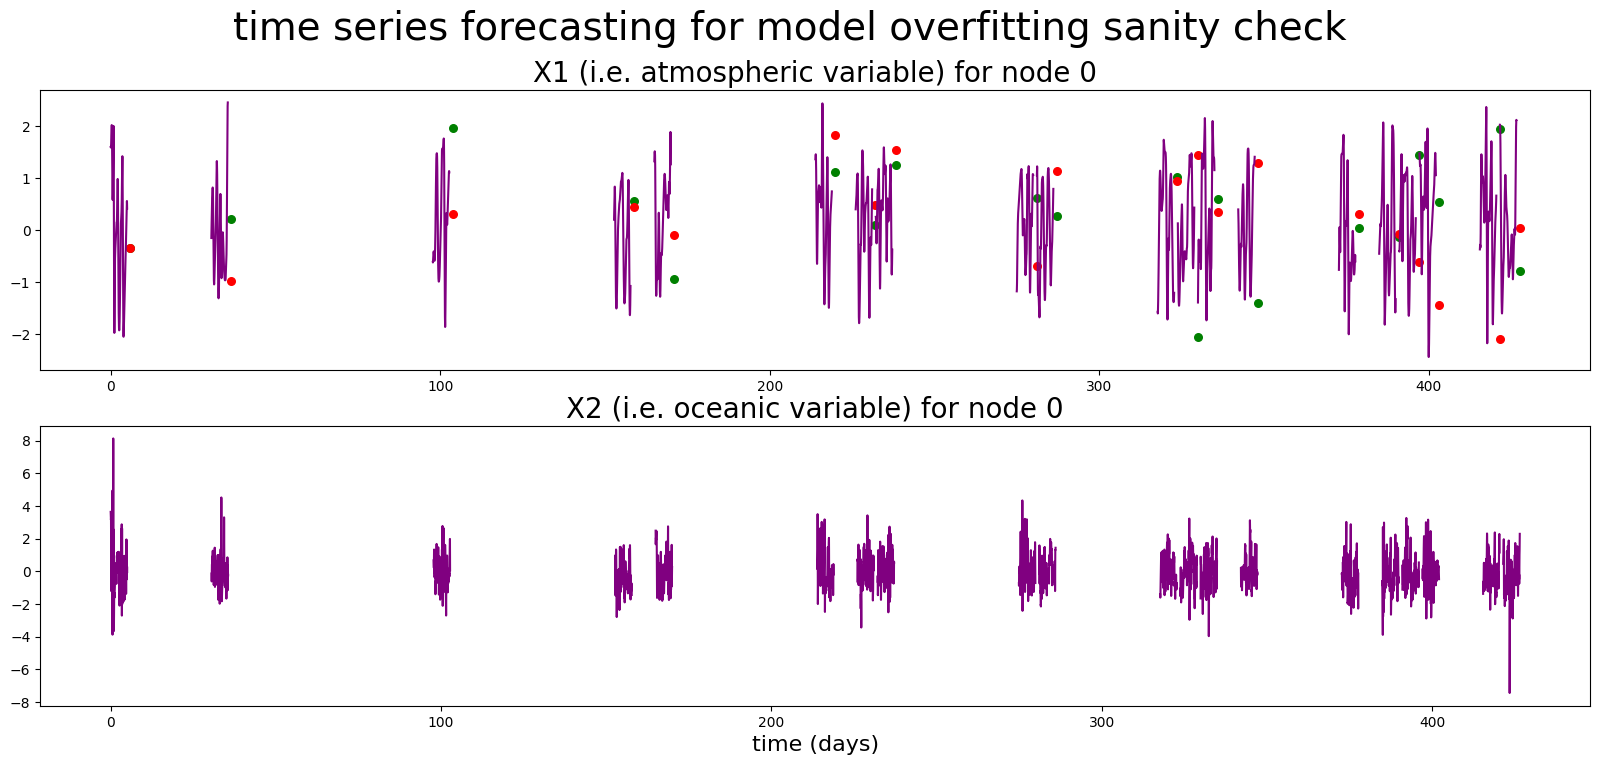

In [13]:
fig, (ax0, ax1) = plot_with_predictions(model=sanity_check_model3,
                                        graph_dataset=overfit_sample,
                                        Loader=MixedLoader,
                                        batch_size=32,
                                        node=0,
                                        model_name='overfitting sanity check')
plt.show()

### train GCN model

In [14]:
GCN_model = GCN(
    n_labels=1,
    channels=32,  # same thing as n_hidden
    activation="relu",
    output_activation=None, # we want regression, i.e. a linear function
    use_bias=False,
    dropout_rate=0,
    l2_reg=0)
GCN_model.compile(
    optimizer='adam',
    loss='mean_squared_error')
history = GCN_model.fit(
    train_loader.load(),
    steps_per_epoch=train_loader.steps_per_epoch,
    epochs=200)

Epoch 1/200
3/3 [==============================] - 1s 10ms/step - loss: 17.6967
Epoch 2/200
3/3 [==============================] - 0s 11ms/step - loss: 11.6035
Epoch 3/200
3/3 [==============================] - 0s 8ms/step - loss: 8.8598
Epoch 4/200
3/3 [==============================] - 0s 10ms/step - loss: 7.3871
Epoch 5/200
3/3 [==============================] - 0s 8ms/step - loss: 6.5089
Epoch 6/200
3/3 [==============================] - 0s 9ms/step - loss: 4.8857
Epoch 7/200
3/3 [==============================] - 0s 9ms/step - loss: 4.1447
Epoch 8/200
3/3 [==============================] - 0s 9ms/step - loss: 3.6417
Epoch 9/200
3/3 [==============================] - 0s 10ms/step - loss: 3.0062
Epoch 10/200
3/3 [==============================] - 0s 8ms/step - loss: 2.8082
Epoch 11/200
3/3 [==============================] - 0s 10ms/step - loss: 2.5769
Epoch 12/200
3/3 [==============================] - 0s 8ms/step - loss: 2.2069
Epoch 13/200
3/3 [==============================] - 0s

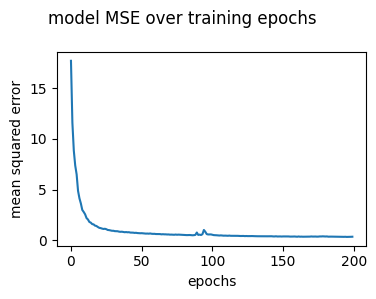

In [15]:
# print(type(history.history))
# print(history.history)
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(history.history['loss'])
ax.set_ylabel('mean squared error')
ax.set_xlabel('epochs')
fig.suptitle('model MSE over training epochs')
plt.tight_layout()
plt.show()

### GCN predictions

visualize predictions on the training set

3/3 [==============================] - 0s 5ms/step


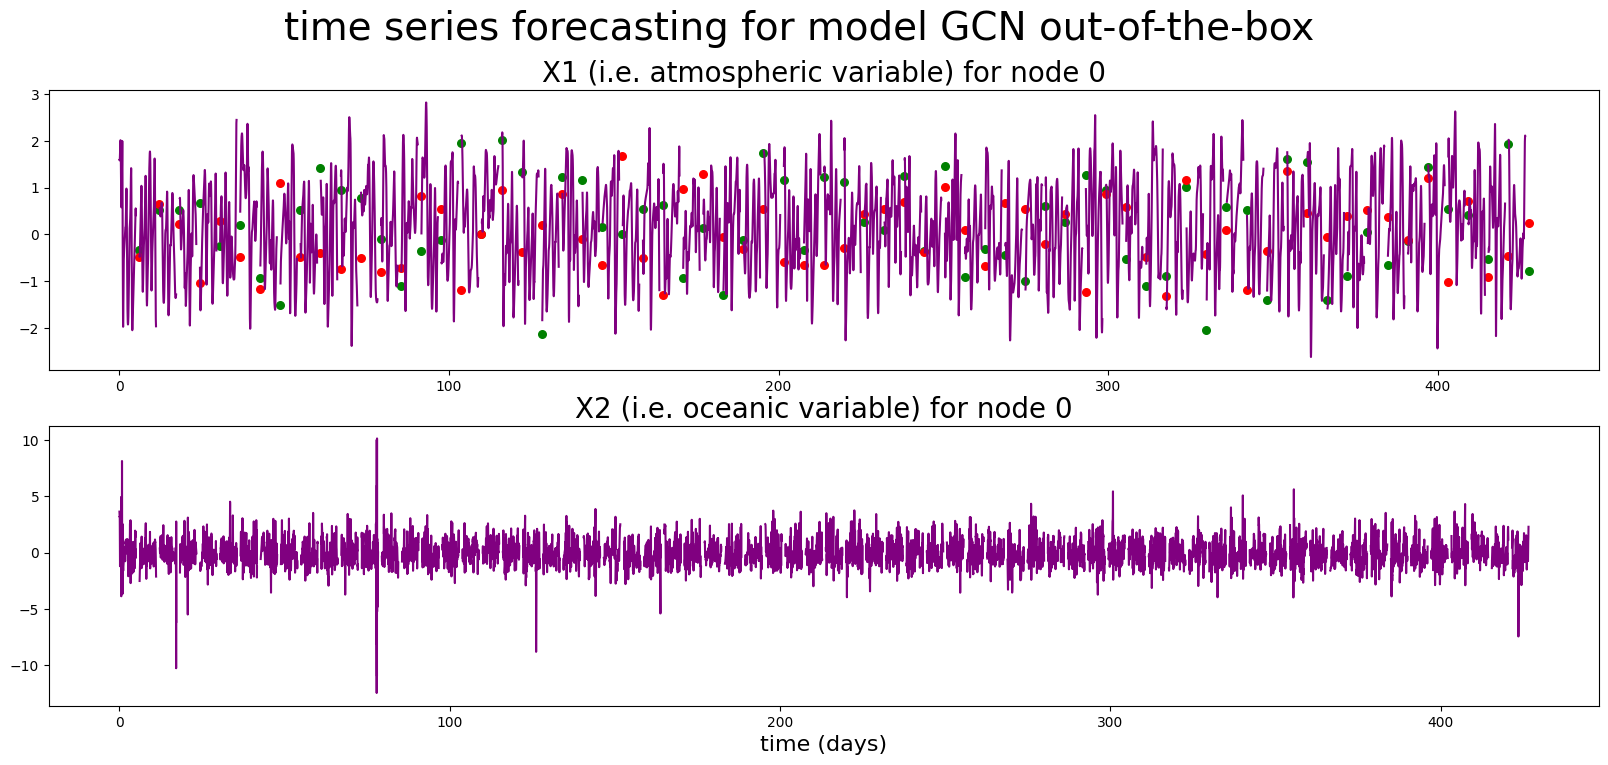

In [16]:
fig, (ax0, ax1) = plot_with_predictions(model=GCN_model,
                                        graph_dataset=train,
                                        Loader=MixedLoader,
                                        batch_size=32,
                                        node=0,
                                        model_name='GCN out-of-the-box')
plt.show()

these predictions are... pretty bad, lol

also, why are we seeing np.shuffle() being called? where is that occurring?

visualize predictions for the validation set

1/1 [==============================] - 0s 29ms/step


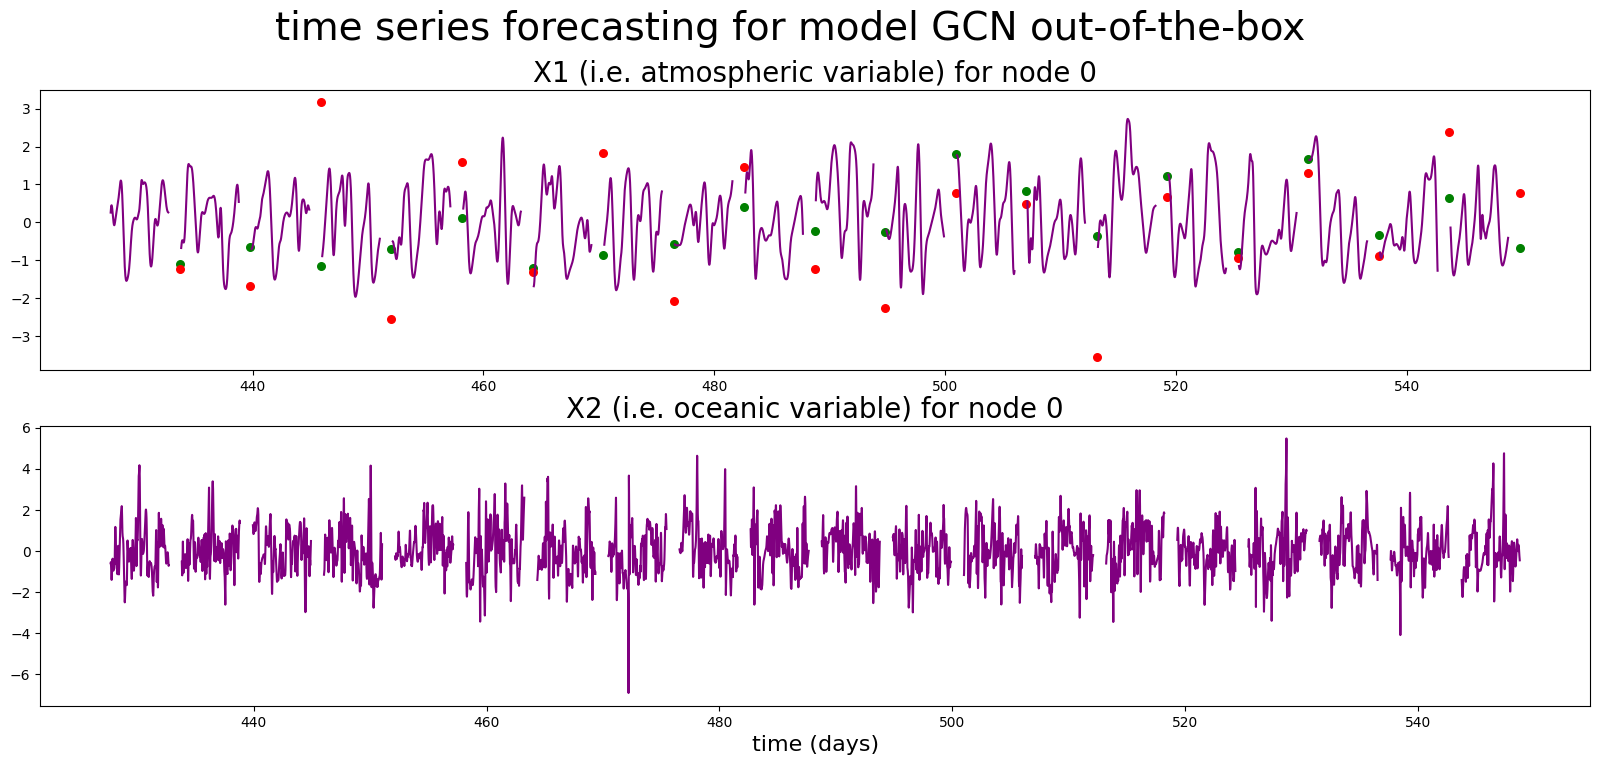

In [17]:
fig, (ax0, ax1) = plot_with_predictions(model=GCN_model,
                                        graph_dataset=val,
                                        Loader=MixedLoader,
                                        batch_size=32,
                                        node=0,
                                        model_name='GCN out-of-the-box')
plt.show()

In [18]:
# TODO: try some different training parameters 
# TODO: try this with continuous windowing and compare this with LSTM ? 

## custom GCN

### define custom model

In [19]:
class customGCN(Model):
    # TODO: something is going super wrong here
    def __init__(self, n_hidden, output_dim, dropout=0.5):
        super().__init__()
        self.gcn0 = GCNConv(n_hidden, activation='relu')
        self.gcn1 = GCNConv(n_hidden, activation='relu')
        self.pool = GlobalSumPool()
        self.dropout0 = Dropout(dropout)
        self.dropout1 = Dropout(dropout)
        self.dense = Dense(units=output_dim,
                           activation=None)  # linear regression layer

    def call(self, inputs):
        # print(type(inputs))
        # print(len(inputs))
        # print('\n\n')
        # print(inputs)
        x, a = inputs
        x = self.dropout0(x)
        x = self.gcn0([x, a])
        x = self.dropout1(x)
        x = self.gcn1([x, a])
        x = self.pool(x)
        out = self.dense(x)
        return out

In [20]:
custom_model = customGCN(n_hidden=32,
                         output_dim=dataset[0].y.shape[-1],
                         dropout=0.5)
custom_model.compile(
    optimizer='adam',
    loss='mean_squared_error')
history = custom_model.fit(
    train_loader.load(),
    steps_per_epoch=train_loader.steps_per_epoch,
    epochs=100)

Epoch 1/100


2022-11-18 13:49:03.796574: W tensorflow/core/framework/op_kernel.cc:1768] INVALID_ARGUMENT: TypeError: `generator` yielded an element that could not be converted to the expected type. The expected type was float64, but the yielded element was SparseTensor(indices=tf.Tensor(
[[ 0  0]
 [ 0  1]
 [ 0 35]
 [ 1  0]
 [ 1  1]
 [ 1  2]
 [ 2  1]
 [ 2  2]
 [ 2  3]
 [ 3  2]
 [ 3  3]
 [ 3  4]
 [ 4  3]
 [ 4  4]
 [ 4  5]
 [ 5  4]
 [ 5  5]
 [ 5  6]
 [ 6  5]
 [ 6  6]
 [ 6  7]
 [ 7  6]
 [ 7  7]
 [ 7  8]
 [ 8  7]
 [ 8  8]
 [ 8  9]
 [ 9  8]
 [ 9  9]
 [ 9 10]
 [10  9]
 [10 10]
 [10 11]
 [11 10]
 [11 11]
 [11 12]
 [12 11]
 [12 12]
 [12 13]
 [13 12]
 [13 13]
 [13 14]
 [14 13]
 [14 14]
 [14 15]
 [15 14]
 [15 15]
 [15 16]
 [16 15]
 [16 16]
 [16 17]
 [17 16]
 [17 17]
 [17 18]
 [18 17]
 [18 18]
 [18 19]
 [19 18]
 [19 19]
 [19 20]
 [20 19]
 [20 20]
 [20 21]
 [21 20]
 [21 21]
 [21 22]
 [22 21]
 [22 22]
 [22 23]
 [23 22]
 [23 23]
 [23 24]
 [24 23]
 [24 24]
 [24 25]
 [25 24]
 [25 25]
 [25 26]
 [26 25]
 [26 26]
 [26

InvalidArgumentError: Graph execution error:

TypeError: `generator` yielded an element that could not be converted to the expected type. The expected type was float64, but the yielded element was SparseTensor(indices=tf.Tensor(
[[ 0  0]
 [ 0  1]
 [ 0 35]
 [ 1  0]
 [ 1  1]
 [ 1  2]
 [ 2  1]
 [ 2  2]
 [ 2  3]
 [ 3  2]
 [ 3  3]
 [ 3  4]
 [ 4  3]
 [ 4  4]
 [ 4  5]
 [ 5  4]
 [ 5  5]
 [ 5  6]
 [ 6  5]
 [ 6  6]
 [ 6  7]
 [ 7  6]
 [ 7  7]
 [ 7  8]
 [ 8  7]
 [ 8  8]
 [ 8  9]
 [ 9  8]
 [ 9  9]
 [ 9 10]
 [10  9]
 [10 10]
 [10 11]
 [11 10]
 [11 11]
 [11 12]
 [12 11]
 [12 12]
 [12 13]
 [13 12]
 [13 13]
 [13 14]
 [14 13]
 [14 14]
 [14 15]
 [15 14]
 [15 15]
 [15 16]
 [16 15]
 [16 16]
 [16 17]
 [17 16]
 [17 17]
 [17 18]
 [18 17]
 [18 18]
 [18 19]
 [19 18]
 [19 19]
 [19 20]
 [20 19]
 [20 20]
 [20 21]
 [21 20]
 [21 21]
 [21 22]
 [22 21]
 [22 22]
 [22 23]
 [23 22]
 [23 23]
 [23 24]
 [24 23]
 [24 24]
 [24 25]
 [25 24]
 [25 25]
 [25 26]
 [26 25]
 [26 26]
 [26 27]
 [27 26]
 [27 27]
 [27 28]
 [28 27]
 [28 28]
 [28 29]
 [29 28]
 [29 29]
 [29 30]
 [30 29]
 [30 30]
 [30 31]
 [31 30]
 [31 31]
 [31 32]
 [32 31]
 [32 32]
 [32 33]
 [33 32]
 [33 33]
 [33 34]
 [34 33]
 [34 34]
 [34 35]
 [35  0]
 [35 34]
 [35 35]], shape=(108, 2), dtype=int64), values=tf.Tensor(
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], shape=(108,), dtype=float64), dense_shape=tf.Tensor([36 36], shape=(2,), dtype=int64)).
Traceback (most recent call last):

  File "/Users/Guest/lorenzGNN/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1054, in generator_py_func
    script_ops.FuncRegistry._convert(  # pylint: disable=protected-access

  File "/Users/Guest/lorenzGNN/venv/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 230, in _convert
    result = np.asarray(value, dtype=dtype, order="C")

TypeError: float() argument must be a string or a real number, not 'SparseTensor'


During handling of the above exception, another exception occurred:


Traceback (most recent call last):

  File "/Users/Guest/lorenzGNN/venv/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/Users/Guest/lorenzGNN/venv/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/Users/Guest/lorenzGNN/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1058, in generator_py_func
    six.reraise(

  File "/Users/Guest/lorenzGNN/venv/lib/python3.10/site-packages/six.py", line 718, in reraise
    raise value.with_traceback(tb)

  File "/Users/Guest/lorenzGNN/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1054, in generator_py_func
    script_ops.FuncRegistry._convert(  # pylint: disable=protected-access

  File "/Users/Guest/lorenzGNN/venv/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 230, in _convert
    result = np.asarray(value, dtype=dtype, order="C")

TypeError: `generator` yielded an element that could not be converted to the expected type. The expected type was float64, but the yielded element was SparseTensor(indices=tf.Tensor(
[[ 0  0]
 [ 0  1]
 [ 0 35]
 [ 1  0]
 [ 1  1]
 [ 1  2]
 [ 2  1]
 [ 2  2]
 [ 2  3]
 [ 3  2]
 [ 3  3]
 [ 3  4]
 [ 4  3]
 [ 4  4]
 [ 4  5]
 [ 5  4]
 [ 5  5]
 [ 5  6]
 [ 6  5]
 [ 6  6]
 [ 6  7]
 [ 7  6]
 [ 7  7]
 [ 7  8]
 [ 8  7]
 [ 8  8]
 [ 8  9]
 [ 9  8]
 [ 9  9]
 [ 9 10]
 [10  9]
 [10 10]
 [10 11]
 [11 10]
 [11 11]
 [11 12]
 [12 11]
 [12 12]
 [12 13]
 [13 12]
 [13 13]
 [13 14]
 [14 13]
 [14 14]
 [14 15]
 [15 14]
 [15 15]
 [15 16]
 [16 15]
 [16 16]
 [16 17]
 [17 16]
 [17 17]
 [17 18]
 [18 17]
 [18 18]
 [18 19]
 [19 18]
 [19 19]
 [19 20]
 [20 19]
 [20 20]
 [20 21]
 [21 20]
 [21 21]
 [21 22]
 [22 21]
 [22 22]
 [22 23]
 [23 22]
 [23 23]
 [23 24]
 [24 23]
 [24 24]
 [24 25]
 [25 24]
 [25 25]
 [25 26]
 [26 25]
 [26 26]
 [26 27]
 [27 26]
 [27 27]
 [27 28]
 [28 27]
 [28 28]
 [28 29]
 [29 28]
 [29 29]
 [29 30]
 [30 29]
 [30 30]
 [30 31]
 [31 30]
 [31 31]
 [31 32]
 [32 31]
 [32 32]
 [32 33]
 [33 32]
 [33 33]
 [33 34]
 [34 33]
 [34 34]
 [34 35]
 [35  0]
 [35 34]
 [35 35]], shape=(108, 2), dtype=int64), values=tf.Tensor(
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], shape=(108,), dtype=float64), dense_shape=tf.Tensor([36 36], shape=(2,), dtype=int64)).


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_44499]